# Feature selection with Boruta-SHAP to increase your score

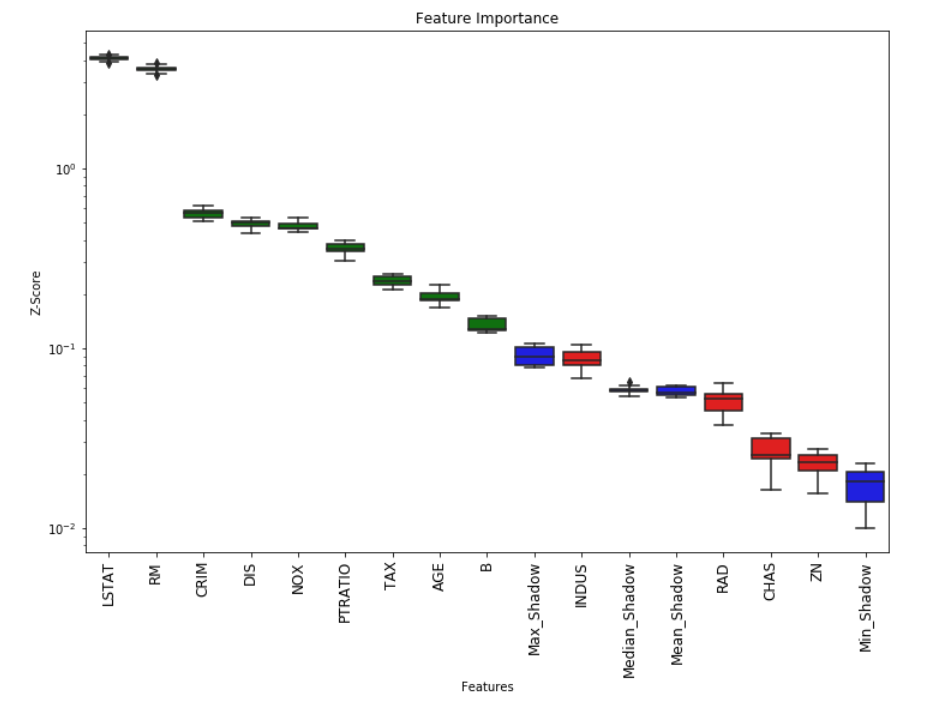

#### In this competition there are quite a few of features. Is there a way to eliminate the unuseful ones? 

Feature selection has important advantages:
 1. by training new useful models that others don't have in their ensemble
 2. by making your models run better

Gradient Boosting incorporates feature selection, since the trees spit only on significant features (or at least they should). In reality, this is not always true as sometimes noisy, irrelevant splits may appear in the tree. Moreover, working with not useful features will cause your training to go slower.

Generally, widely recognized benefits of featue selection are:

* simplification of models to make them easier to interpret
* shorter training times,
* to avoid the curse of dimensionality,
* more generalization by reducing overfitting (reduction of variance)

Boruta-SHAP is a package combining Boruta (https://github.com/scikit-learn-contrib/boruta_py), a feature selection method based on repeated tests of the importance of a feature in a model, with the interpretability method SHAP (https://christophm.github.io/interpretable-ml-book/shap.html).

Boruta-SHAP, developed by Eoghan Keany (https://github.com/Ekeany/Boruta-Shap), is extremely simple to use: get your best model, let it run some time on Boruta-SHAP and evaluate the results!

p.s
p.s. You can read more about Boruta-SHAP on this Medium article by the author: https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677

#### Let's start by uploading packages and data

In [1]:
!pip install BorutaShap

In [2]:
!pip install scikit-learn -U

     |████████████████████████████████| 23.1 MB 65.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 1.0 which is incompatible.


In [3]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
from functools import partial

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Feature selection
from BorutaShap import BorutaShap
from xgboost import XGBClassifier

# Validation
from sklearn.model_selection import KFold, StratifiedKFold

2021-10-02 14:11:16.488251: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
# Derived from the original script https://www.kaggle.com/gemartin/load-data-reduce-memory-usage 
# by Guillaume Martin

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
## Loading data 
X_train = pd.read_csv("../input/tabular-playground-series-oct-2021/train.csv").set_index('id')
X_test = pd.read_csv("../input/tabular-playground-series-oct-2021/test.csv").set_index('id')

# Feature engineering
unique_values = X_train.iloc[:1000].nunique()
categoricals = [col for col in  unique_values.index[unique_values < 10] if col!='target']
numeric = [col for col in X_test.columns if col not in categoricals]

X_train['mean_numeric'] = X_train[numeric].mean(axis=1)
X_train['std_numeric'] = X_train[numeric].std(axis=1)
X_train['min_numeric'] = X_train[numeric].min(axis=1)
X_train['max_numeric'] = X_train[numeric].max(axis=1)
X_train['sum_categoricals'] = X_train[categoricals].sum(axis=1)

X_test['mean_numeric'] = X_test[numeric].mean(axis=1)
X_test['std_numeric'] = X_test[numeric].std(axis=1)
X_test['min_numeric'] = X_test[numeric].min(axis=1)
X_test['max_numeric'] = X_test[numeric].max(axis=1)
X_test['sum_categoricals'] = X_test[categoricals].sum(axis=1)

# Sampling for speeding up things
X_train = X_train.sample(n=200_000, random_state=0)

# target
y_train = X_train.target
X_train = X_train.drop('target', axis='columns')

#### Now we pick our best model and let Boruta-SHAP run a few experiments (usually 50 are enough) before getting the results.

#### We cross-validate our experiments in order to ascertain that we are indeed picking the right variables

#### as the results are prepared and we can plot them to visualize the Z-scores intervals of our features. That will signal us the confidence of the choice made by the algorithm in selecting or rejecting features.

#### Please notice that the last two features are noisy features used by Boruta-SHAP to fgure out the important features. Clearly they are non-significant.

#### Cross-validation takes time. Meanwhile we can grab a cup of coffee and relax as Boruta-SHAP is doing all the heavy-lift job.

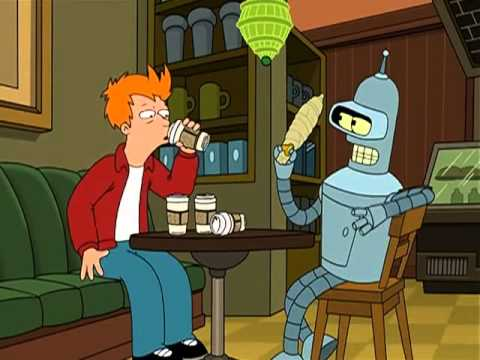

FOLD 1/5


  0%|          | 0/50 [00:00<?, ?it/s]

86 attributes confirmed important: ['f14', 'f13', 'f26', 'f63', 'f266', 'f8', 'f247', 'f78', 'f112', 'f138', 'f96', 'f201', 'f4', 'f187', 'f195', 'f92', 'f5', 'f56', 'f22', 'f1', 'f143', 'f74', 'f17', 'f53', 'f86', 'f214', 'f258', 'f40', 'f85', 'f75', 'f3', 'f6', 'f18', 'f73', 'f130', 'f139', 'f241', 'f144', 'f152', 'f69', 'f213', 'f99', 'f95', 'f150', 'f103', 'f136', 'f119', 'f77', 'f12', 'f43', 'f19', 'f62', 'f42', 'f252', 'f107', 'f163', 'f154', 'f7', 'f82', 'f125', 'f179', 'f211', 'f16', 'f90', 'f52', 'f20', 'f156', 'f29', 'f2', 'f169', 'f33', 'std_numeric', 'f65', 'mean_numeric', 'f200', 'f134', 'f58', 'f44', 'f243', 'f227', 'f71', 'f192', 'f72', 'f48', 'f93', 'sum_categoricals']
199 attributes confirmed unimportant: ['f186', 'f162', 'f66', 'f274', 'f176', 'f35', 'f47', 'f273', 'f54', 'f253', 'f208', 'f203', 'f233', 'f122', 'f155', 'f36', 'f263', 'f240', 'f256', 'f34', 'f41', 'max_numeric', 'f57', 'f83', 'f124', 'f230', 'f225', 'f111', 'f84', 'f264', 'f102', 'f171', 'f120', 'f277'

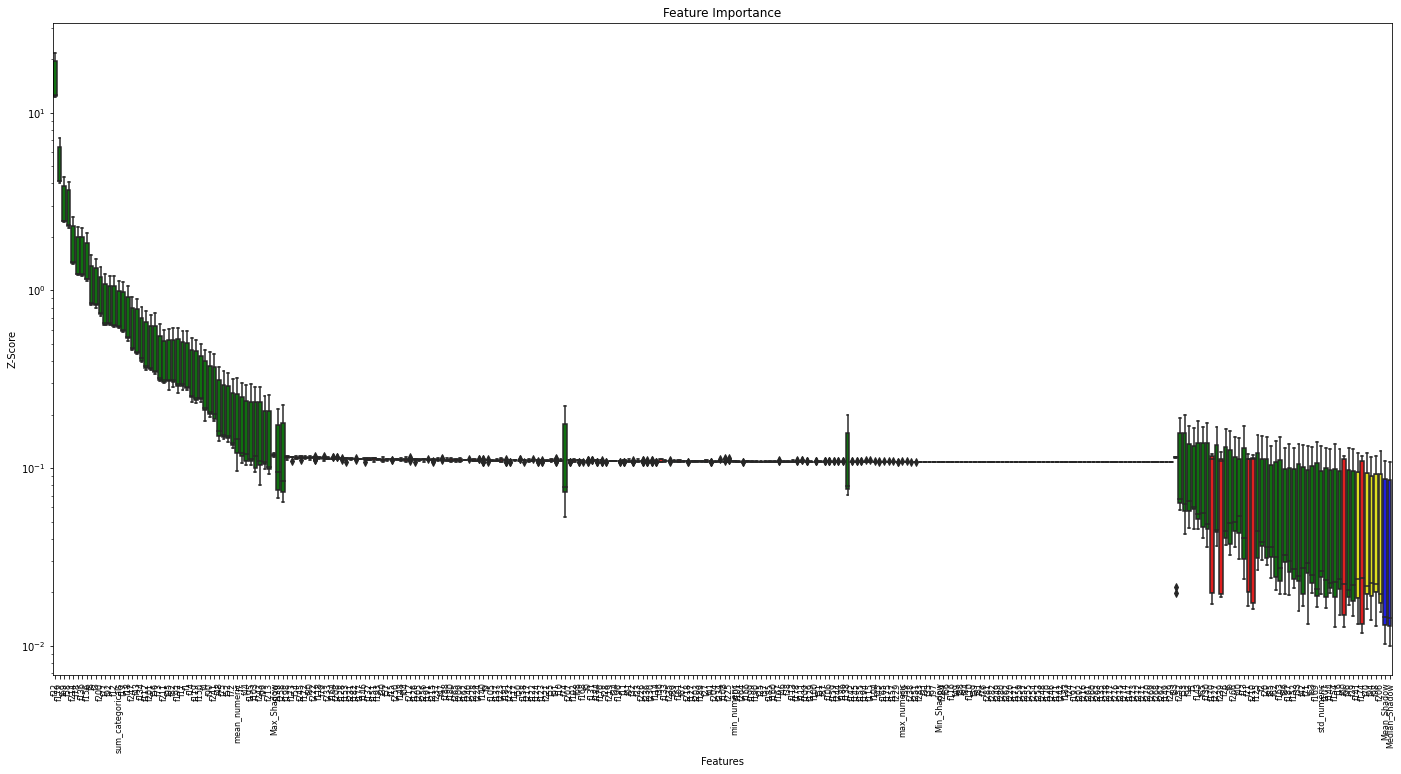

Selected features at fold 1 are: ['f1', 'f103', 'f107', 'f112', 'f119', 'f12', 'f125', 'f13', 'f130', 'f134', 'f136', 'f138', 'f139', 'f14', 'f143', 'f144', 'f150', 'f152', 'f154', 'f156', 'f16', 'f163', 'f169', 'f17', 'f179', 'f18', 'f187', 'f19', 'f192', 'f195', 'f2', 'f20', 'f200', 'f201', 'f211', 'f213', 'f214', 'f22', 'f227', 'f241', 'f243', 'f247', 'f252', 'f258', 'f26', 'f266', 'f29', 'f3', 'f33', 'f4', 'f40', 'f42', 'f43', 'f44', 'f48', 'f5', 'f52', 'f53', 'f56', 'f58', 'f6', 'f62', 'f63', 'f65', 'f69', 'f7', 'f71', 'f72', 'f73', 'f74', 'f75', 'f77', 'f78', 'f8', 'f82', 'f85', 'f86', 'f90', 'f92', 'f93', 'f95', 'f96', 'f99', 'mean_numeric', 'std_numeric', 'sum_categoricals']
FOLD 2/5


  0%|          | 0/50 [00:00<?, ?it/s]

76 attributes confirmed important: ['f150', 'f20', 'f103', 'f156', 'f136', 'f5', 'f2', 'f119', 'f56', 'f169', 'f154', 'std_numeric', 'f22', 'f1', 'f65', 'mean_numeric', 'f200', 'f134', 'f77', 'f143', 'f12', 'f14', 'f58', 'f13', 'f44', 'f74', 'f17', 'f26', 'f43', 'f53', 'f243', 'f214', 'f19', 'f63', 'f42', 'f258', 'f252', 'f227', 'f40', 'f266', 'f75', 'f8', 'f3', 'f247', 'f192', 'f78', 'f112', 'f138', 'f6', 'f18', 'f7', 'f72', 'f48', 'f4', 'f73', 'f82', 'f139', 'f201', 'f241', 'f187', 'f195', 'f93', 'f152', 'f125', 'f92', 'f179', 'f69', 'f213', 'f211', 'f16', 'f239', 'f99', 'sum_categoricals', 'f95', 'f90', 'f52']
200 attributes confirmed unimportant: ['f186', 'f162', 'f66', 'f274', 'f176', 'f35', 'f47', 'f273', 'f54', 'f253', 'f233', 'f203', 'f122', 'f155', 'f36', 'f263', 'f240', 'f256', 'f41', 'max_numeric', 'f57', 'f206', 'f94', 'f124', 'f230', 'f225', 'f111', 'f84', 'f264', 'f102', 'f171', 'f120', 'f277', 'f168', 'f177', 'f210', 'f160', 'f207', 'f9', 'f279', 'f159', 'f276', 'f188', 

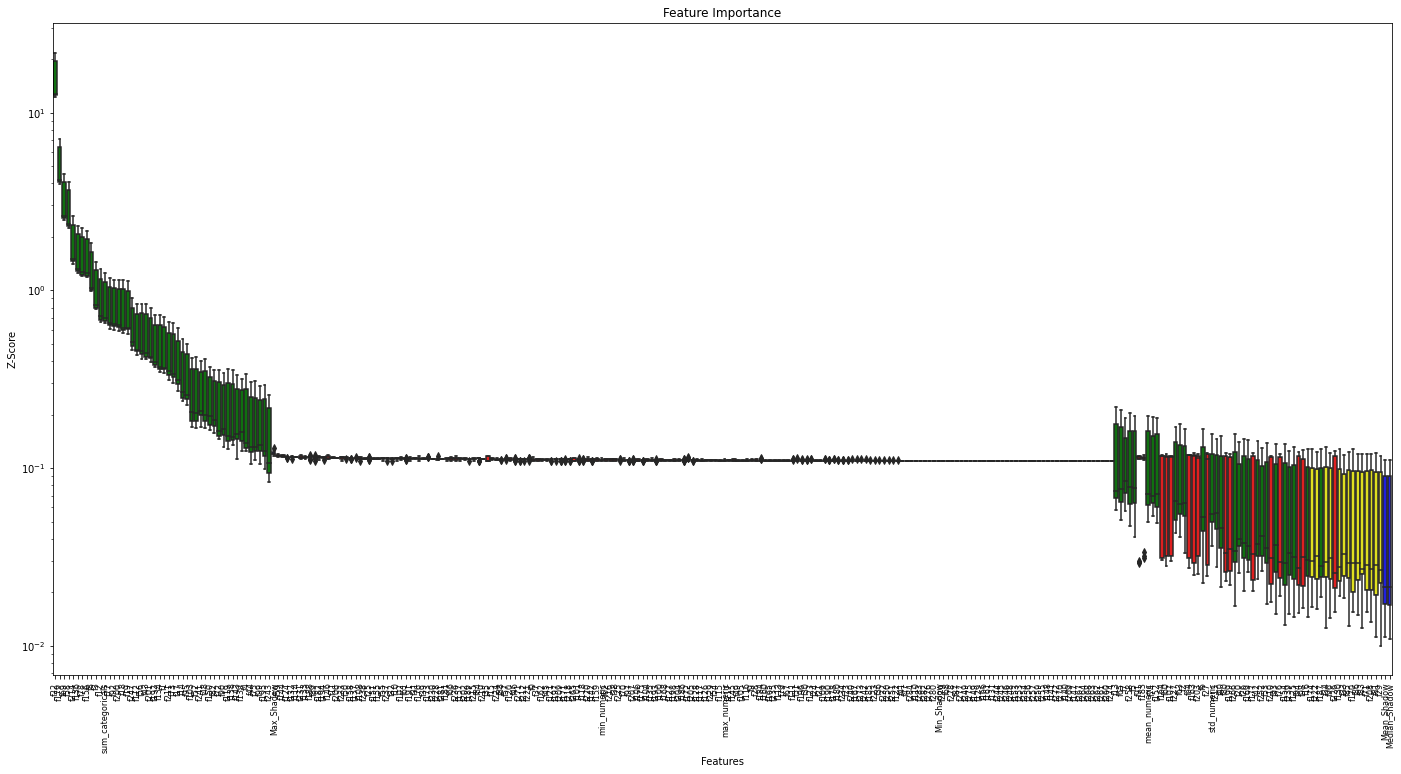

Selected features at fold 2 are: ['f1', 'f103', 'f112', 'f119', 'f12', 'f125', 'f13', 'f134', 'f136', 'f138', 'f139', 'f14', 'f143', 'f150', 'f152', 'f154', 'f156', 'f16', 'f169', 'f17', 'f179', 'f18', 'f187', 'f19', 'f192', 'f195', 'f2', 'f20', 'f200', 'f201', 'f211', 'f213', 'f214', 'f22', 'f227', 'f239', 'f241', 'f243', 'f247', 'f252', 'f258', 'f26', 'f266', 'f3', 'f4', 'f40', 'f42', 'f43', 'f44', 'f48', 'f5', 'f52', 'f53', 'f56', 'f58', 'f6', 'f63', 'f65', 'f69', 'f7', 'f72', 'f73', 'f74', 'f75', 'f77', 'f78', 'f8', 'f82', 'f90', 'f92', 'f93', 'f95', 'f99', 'mean_numeric', 'std_numeric', 'sum_categoricals']
FOLD 3/5


  0%|          | 0/50 [00:00<?, ?it/s]

80 attributes confirmed important: ['f14', 'f13', 'f26', 'f266', 'f8', 'f247', 'f78', 'f112', 'f138', 'f96', 'f4', 'f201', 'f195', 'f92', 'f239', 'f5', 'f56', 'f22', 'f1', 'f143', 'f74', 'f17', 'f53', 'f214', 'f258', 'f85', 'f75', 'f3', 'f231', 'f6', 'f18', 'f73', 'f130', 'f139', 'f241', 'f152', 'f69', 'f213', 'f99', 'f95', 'f150', 'f103', 'f136', 'f119', 'f127', 'f77', 'f12', 'f43', 'f19', 'f62', 'f42', 'f252', 'f7', 'f82', 'f125', 'f179', 'f211', 'f16', 'f90', 'f52', 'f20', 'f156', 'f29', 'f2', 'f169', 'f33', 'f65', 'mean_numeric', 'f200', 'f134', 'f58', 'f44', 'f243', 'f192', 'f141', 'f72', 'f48', 'f173', 'f98', 'sum_categoricals']
197 attributes confirmed unimportant: ['f186', 'f162', 'f66', 'f274', 'f176', 'f35', 'f47', 'f273', 'f54', 'f253', 'f208', 'f203', 'f233', 'f122', 'f155', 'f36', 'f263', 'f240', 'f256', 'f34', 'f41', 'max_numeric', 'f57', 'f83', 'f94', 'f206', 'f124', 'f230', 'f225', 'f111', 'f84', 'f264', 'f102', 'f171', 'f120', 'f277', 'f168', 'f177', 'f210', 'f160', 'f

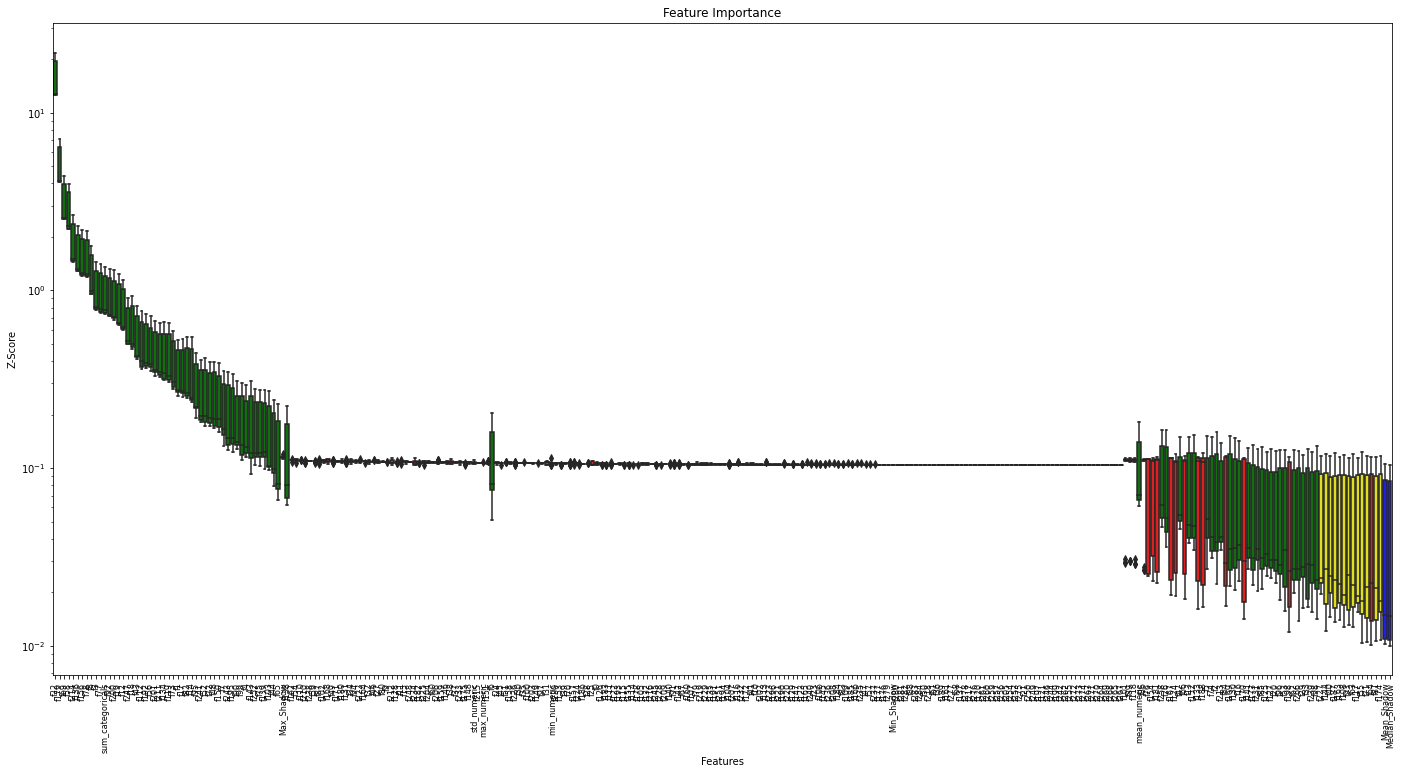

Selected features at fold 3 are: ['f1', 'f103', 'f112', 'f119', 'f12', 'f125', 'f127', 'f13', 'f130', 'f134', 'f136', 'f138', 'f139', 'f14', 'f141', 'f143', 'f150', 'f152', 'f156', 'f16', 'f169', 'f17', 'f173', 'f179', 'f18', 'f19', 'f192', 'f195', 'f2', 'f20', 'f200', 'f201', 'f211', 'f213', 'f214', 'f22', 'f231', 'f239', 'f241', 'f243', 'f247', 'f252', 'f258', 'f26', 'f266', 'f29', 'f3', 'f33', 'f4', 'f42', 'f43', 'f44', 'f48', 'f5', 'f52', 'f53', 'f56', 'f58', 'f6', 'f62', 'f65', 'f69', 'f7', 'f72', 'f73', 'f74', 'f75', 'f77', 'f78', 'f8', 'f82', 'f85', 'f90', 'f92', 'f95', 'f96', 'f98', 'f99', 'mean_numeric', 'sum_categoricals']
FOLD 4/5


  0%|          | 0/50 [00:00<?, ?it/s]

80 attributes confirmed important: ['f14', 'f13', 'f26', 'f63', 'f266', 'f83', 'f8', 'f247', 'f78', 'f112', 'f138', 'f96', 'f4', 'f201', 'f195', 'f92', 'f5', 'f56', 'f22', 'f1', 'f143', 'f74', 'f17', 'f53', 'f214', 'f258', 'f40', 'f75', 'f3', 'f6', 'f18', 'f73', 'f139', 'f241', 'f152', 'f69', 'f213', 'f99', 'f95', 'f150', 'f103', 'f136', 'f119', 'f127', 'f77', 'f12', 'f43', 'f19', 'f42', 'f154', 'f7', 'f82', 'f125', 'f179', 'f211', 'f16', 'f90', 'f52', 'f20', 'f156', 'f2', 'f169', 'f33', 'std_numeric', 'mean_numeric', 'f65', 'f200', 'f134', 'f58', 'f44', 'f243', 'f227', 'f71', 'f192', 'f72', 'f48', 'f93', 'f222', 'f98', 'sum_categoricals']
200 attributes confirmed unimportant: ['f186', 'f162', 'f66', 'f274', 'f176', 'f35', 'f47', 'f273', 'f54', 'f253', 'f208', 'f203', 'f233', 'f122', 'f155', 'f36', 'f263', 'f240', 'f256', 'f34', 'f41', 'max_numeric', 'f57', 'f94', 'f206', 'f124', 'f230', 'f225', 'f111', 'f84', 'f264', 'f187', 'f102', 'f171', 'f120', 'f277', 'f168', 'f177', 'f210', 'f16

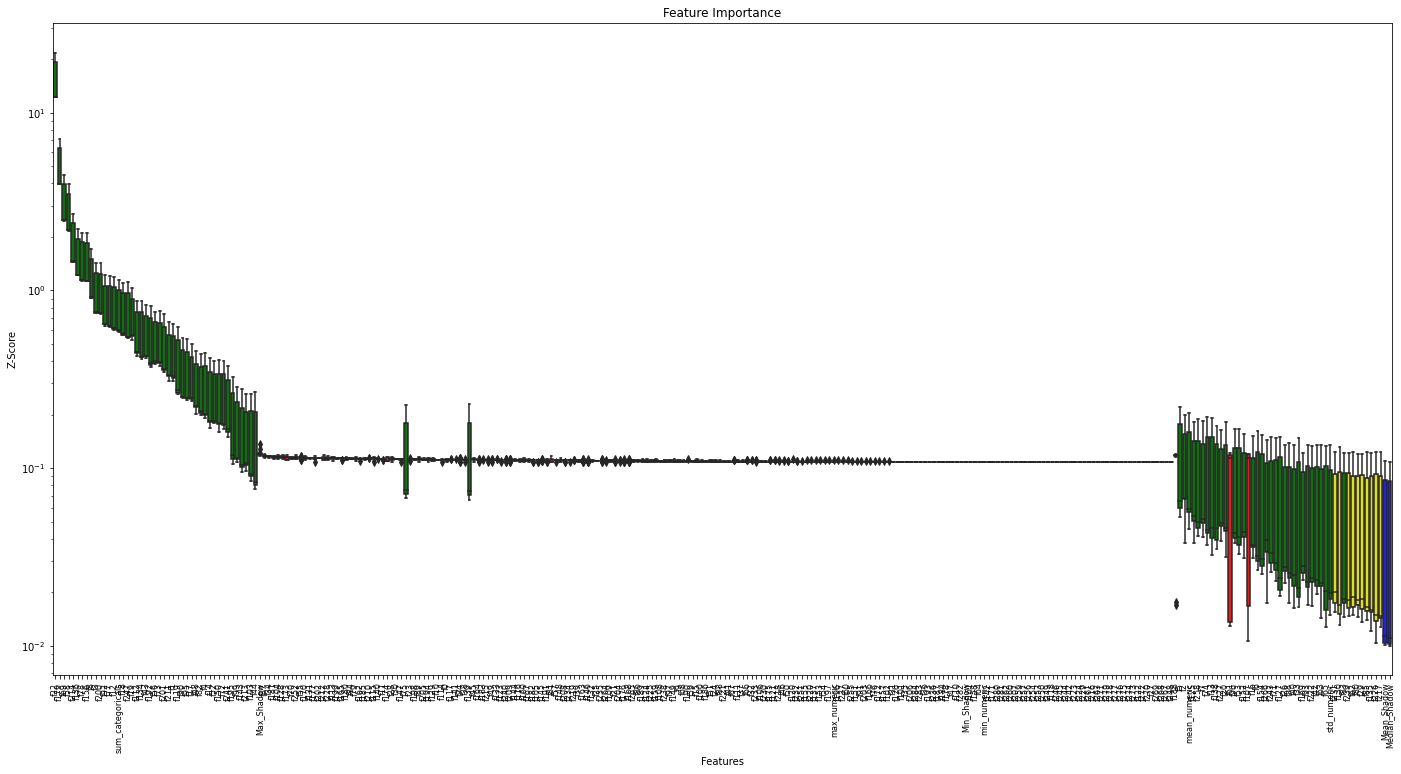

Selected features at fold 4 are: ['f1', 'f103', 'f112', 'f119', 'f12', 'f125', 'f127', 'f13', 'f134', 'f136', 'f138', 'f139', 'f14', 'f143', 'f150', 'f152', 'f154', 'f156', 'f16', 'f169', 'f17', 'f179', 'f18', 'f19', 'f192', 'f195', 'f2', 'f20', 'f200', 'f201', 'f211', 'f213', 'f214', 'f22', 'f222', 'f227', 'f241', 'f243', 'f247', 'f258', 'f26', 'f266', 'f3', 'f33', 'f4', 'f40', 'f42', 'f43', 'f44', 'f48', 'f5', 'f52', 'f53', 'f56', 'f58', 'f6', 'f63', 'f65', 'f69', 'f7', 'f71', 'f72', 'f73', 'f74', 'f75', 'f77', 'f78', 'f8', 'f82', 'f83', 'f90', 'f92', 'f93', 'f95', 'f96', 'f98', 'f99', 'mean_numeric', 'std_numeric', 'sum_categoricals']
FOLD 5/5


  0%|          | 0/50 [00:00<?, ?it/s]

78 attributes confirmed important: ['f14', 'f13', 'f26', 'f63', 'f8', 'f247', 'f78', 'f112', 'f138', 'f96', 'f4', 'f201', 'f195', 'f92', 'f64', 'f5', 'f56', 'f22', 'f1', 'f143', 'f27', 'f74', 'f17', 'f53', 'f214', 'f86', 'f258', 'f40', 'f75', 'f3', 'f6', 'f18', 'f73', 'f139', 'f241', 'f152', 'f69', 'f213', 'f99', 'f95', 'f150', 'f103', 'f136', 'f119', 'f77', 'f12', 'f60', 'f43', 'f19', 'f252', 'f198', 'f7', 'f82', 'f125', 'f179', 'f211', 'f16', 'f90', 'f52', 'f156', 'f2', 'f169', 'f33', 'std_numeric', 'f65', 'mean_numeric', 'f200', 'f134', 'f58', 'f44', 'f243', 'f71', 'f192', 'f72', 'f48', 'f173', 'f98', 'sum_categoricals']
196 attributes confirmed unimportant: ['f162', 'f66', 'f274', 'f176', 'f35', 'f47', 'f273', 'f54', 'f253', 'f208', 'f203', 'f233', 'f122', 'f155', 'f36', 'f263', 'f240', 'f256', 'f41', 'max_numeric', 'f57', 'f266', 'f94', 'f206', 'f124', 'f230', 'f225', 'f111', 'f84', 'f264', 'f187', 'f102', 'f171', 'f120', 'f277', 'f168', 'f177', 'f210', 'f160', 'f207', 'f9', 'f279

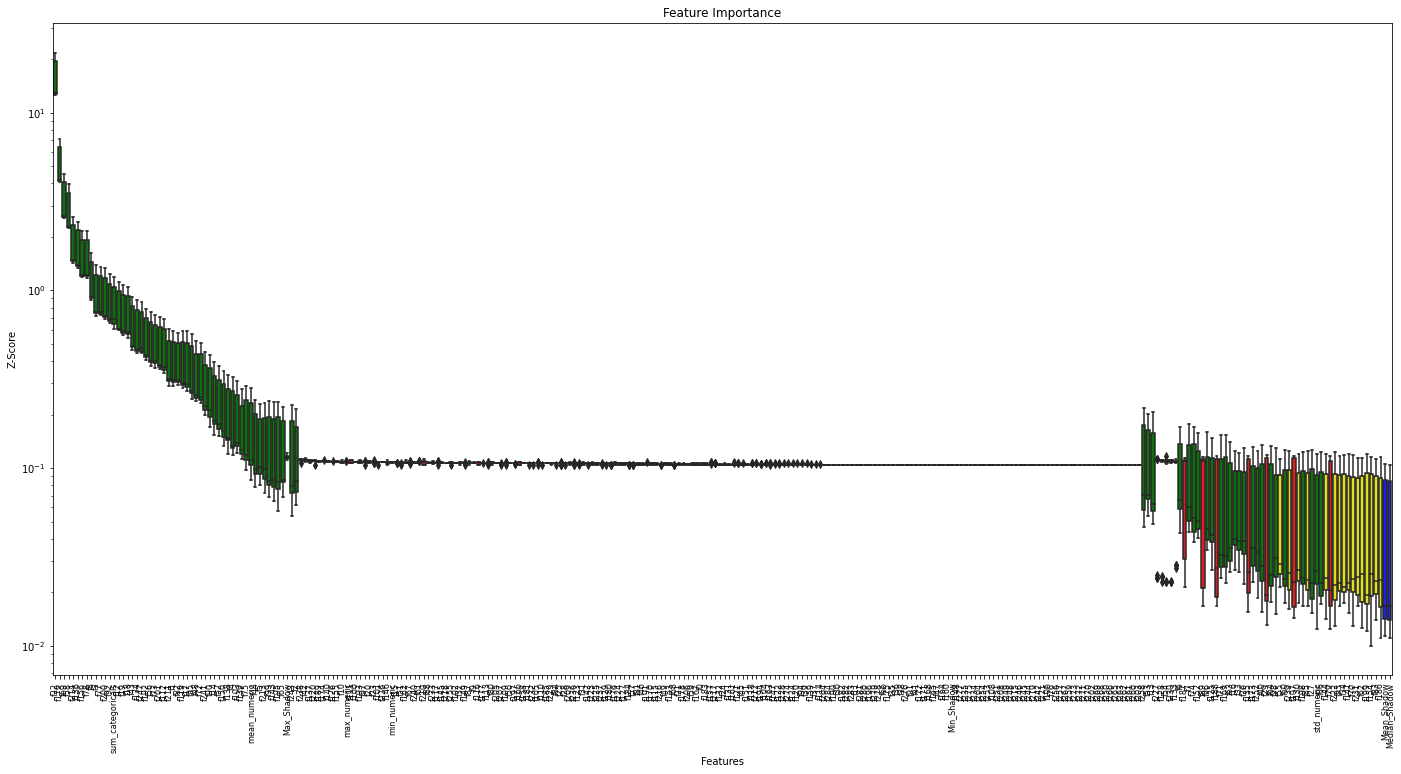

Selected features at fold 5 are: ['f1', 'f103', 'f112', 'f119', 'f12', 'f125', 'f13', 'f134', 'f136', 'f138', 'f139', 'f14', 'f143', 'f150', 'f152', 'f156', 'f16', 'f169', 'f17', 'f173', 'f179', 'f18', 'f19', 'f192', 'f195', 'f198', 'f2', 'f200', 'f201', 'f211', 'f213', 'f214', 'f22', 'f241', 'f243', 'f247', 'f252', 'f258', 'f26', 'f27', 'f3', 'f33', 'f4', 'f40', 'f43', 'f44', 'f48', 'f5', 'f52', 'f53', 'f56', 'f58', 'f6', 'f60', 'f63', 'f64', 'f65', 'f69', 'f7', 'f71', 'f72', 'f73', 'f74', 'f75', 'f77', 'f78', 'f8', 'f82', 'f86', 'f90', 'f92', 'f95', 'f96', 'f98', 'f99', 'mean_numeric', 'std_numeric', 'sum_categoricals']


In [6]:
folds = 5
kf = KFold(n_splits=folds,
           shuffle=True, 
           random_state=0)

selected_columns = list()
    
for k, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    
    print(f"FOLD {k+1}/{folds}")
    
    model = XGBClassifier(
        colsample_bytree= 0.50, 
        subsample= 0.50, 
        learning_rate= 0.012, 
        max_depth= 3, 
        min_child_weight= 252,
        n_estimators= 1000,
        random_state=0,
        use_label_encoder=False,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='gpu_hist',
        gpu_id=0,
        predictor='gpu_predictor'
     )
    
    Feature_Selector = BorutaShap(model=model,
                                  importance_measure='shap', 
                                  classification=True)

    Feature_Selector.fit(X=X_train.iloc[train_idx, :], y=y_train.iloc[train_idx], 
                         n_trials=50, random_state=0)
    
    Feature_Selector.plot(which_features='all', figsize=(24,12))
    
    selected_columns.append(sorted(Feature_Selector.Subset().columns))
    
    print(f"Selected features at fold {k+1} are: {selected_columns[-1]}")

#### Here we finally have the good set of features to be used in this competition (at least using XGBoost - better to test for other algorithms)

In [7]:
final_selection = sorted({item for selection in selected_columns for item in selection})
print(final_selection)

['f1', 'f103', 'f107', 'f112', 'f119', 'f12', 'f125', 'f127', 'f13', 'f130', 'f134', 'f136', 'f138', 'f139', 'f14', 'f141', 'f143', 'f144', 'f150', 'f152', 'f154', 'f156', 'f16', 'f163', 'f169', 'f17', 'f173', 'f179', 'f18', 'f187', 'f19', 'f192', 'f195', 'f198', 'f2', 'f20', 'f200', 'f201', 'f211', 'f213', 'f214', 'f22', 'f222', 'f227', 'f231', 'f239', 'f241', 'f243', 'f247', 'f252', 'f258', 'f26', 'f266', 'f27', 'f29', 'f3', 'f33', 'f4', 'f40', 'f42', 'f43', 'f44', 'f48', 'f5', 'f52', 'f53', 'f56', 'f58', 'f6', 'f60', 'f62', 'f63', 'f64', 'f65', 'f69', 'f7', 'f71', 'f72', 'f73', 'f74', 'f75', 'f77', 'f78', 'f8', 'f82', 'f83', 'f85', 'f86', 'f90', 'f92', 'f93', 'f95', 'f96', 'f98', 'f99', 'mean_numeric', 'std_numeric', 'sum_categoricals']


## Happy Kaggling!